In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from parameters import ParameterSpace, ParameterSet, ParameterRange
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import h5py
import scipy.signal as ss
from hay2011_network_parameters import (networkParameters, population_names,
                                        population_sizes)
from plotting import remove_axis_junk
from lfpykernels import KernelApprox, GaussCylinderPotential
import example_network_methods as methods
import hay2011_network_parameters as params
import scipy.stats as st
from copy import deepcopy
from plotting import draw_lineplot, annotate_subplot
import plotting
from lfpykit import CurrentDipoleMoment, LaminarCurrentSourceDensity
import json
import hashlib
import pandas as pd
from time import time
import neuron

In [3]:
plt.rcParams.update(plotting.rcParams)
golden_ratio = plotting.golden_ratio
figwidth = plotting.figwidth

In [4]:
PS0 = ParameterSpace('hay2011_PS0.txt')
PS1 = ParameterSpace('hay2011_PS1.txt')
PS2 = ParameterSpace('hay2011_PS2.txt')

In [5]:
PS0['weight_scaling'] = ParameterRange([1.0, 1.025, 1.05, 1.075])

In [6]:
# ignore quasi-linearization
PS2['biophys'] = ParameterRange(['frozen'])
PS2

{'weight_EE': ParameterRange([0.00015]),
 'weight_IE': ParameterRange([0.000125]),
 'weight_EI': ParameterRange([0.0045]),
 'weight_II': ParameterRange([0.002]),
 'weight_scaling': ParameterRange([1.0]),
 'biophys': ParameterRange(['frozen']),
 'n_ext': ParameterRange([[920, 160]]),
 't_E': ParameterRange([200.0]),
 't_I': ParameterRange([400.0]),
 'g_eff': ParameterRange([True]),
 'perseg_Vrest': ParameterRange([False])}

In [7]:
neuron.load_mechanisms('mod')

True

In [8]:
TRANSIENT = 2000
dt = networkParameters['dt']
tau = 100  # time lag relative to spike for kernel predictions

In [24]:
# ss.welch/plt.mlab.psd/csd settings
Fs = 1000 / dt
NFFT = 1024 * 2
noverlap = 768 * 2
detrend = False
freqs_cutoff = 1000.  # (Hz) ignore freqs above this in spectra

In [10]:
# low-pass filter settings
N = 2  # filter order
rp = 0.1  # ripple in passband (dB)
rs = 40.  # minimum attenuation required in the stop band (dB)
fc = 100.  # critical frequency (Hz)

# filter coefficients on 'sos' format
sos_ellip = ss.ellip(N=N, rp=rp, rs=rs, Wn=fc, btype='lp', fs=Fs, output='sos')

In [11]:
# E and I colors
colors = ['tab:blue', 'tab:red']

In [12]:
# get a ground truth parameterset list where 'weight_scaling' is varied
# which is used to extract spike rates and ground truth signals
for pset in PS1.iter_inner():
    break
pset['weight_scaling'] = PS0['weight_scaling']
for key in ['biophys', 'i_syn', 'g_eff', 'perseg_Vrest']:
    pset.pop(key)
PS_ref = ParameterSpace(pset)

for pset_ref in PS_ref.iter_inner():
    js_ref = json.dumps(pset_ref, sort_keys=True).encode()
    md5_ref = hashlib.md5(js_ref).hexdigest()
    OUTPUTPATH_REF = os.path.join('output', md5_ref)
    print(OUTPUTPATH_REF, os.path.isdir(OUTPUTPATH_REF))

output/bd376b4b1eddf933a57b63ab836f3f98 True
output/afaee48e9ffd37cd954dd7d1cacdc535 True
output/e01eadb8ce4f85504f04a767c9e20eef True
output/217a4aa867733a2c9acdc748e94950c1 True


In [13]:
# flag; if True, use the median membrane potential per compartment for kernel predictions 
# perseg_Vrest = [False, True]

In [14]:
# flag; if True, use the median membrane potential per compartment for kernel predictions 
PS2['perseg_Vrest'] = ParameterRange([False, True])
PS2

{'weight_EE': ParameterRange([0.00015]),
 'weight_IE': ParameterRange([0.000125]),
 'weight_EI': ParameterRange([0.0045]),
 'weight_II': ParameterRange([0.002]),
 'weight_scaling': ParameterRange([1.0]),
 'biophys': ParameterRange(['frozen']),
 'n_ext': ParameterRange([[920, 160]]),
 't_E': ParameterRange([200.0]),
 't_I': ParameterRange([400.0]),
 'g_eff': ParameterRange([True]),
 'perseg_Vrest': ParameterRange([False, True])}

In [15]:
# Compute spike-LFP and spike-dipole moment kernel approximations
# obtained using the KernelApprox class. 

# outer iterator over the different ground truth datasets
# as we need some Vrest value to linearize around
# as well as the population firing rates
H_YX_pred_all = dict()

for pset_ref in PS_ref.iter_inner():
    js_ref = json.dumps(pset_ref, sort_keys=True).encode()
    md5_ref = hashlib.md5(js_ref).hexdigest()
    OUTPUTPATH_REF = os.path.join('output', md5_ref)
    print(OUTPUTPATH_REF, os.path.isdir(OUTPUTPATH_REF))

    # kernel container
    H_YX_pred = dict()
    for k, pset in enumerate(PS2.iter_inner()):
        # parameters.
        pset['weight_scaling'] = pset_ref['weight_scaling']  # use reference value!
        
        weight_EE = pset['weight_EE']
        weight_IE = pset['weight_IE']
        weight_EI = pset['weight_EI']
        weight_II = pset['weight_II']
        weight_scaling = pset['weight_scaling'] 
        biophys = pset['biophys']
        n_ext = pset['n_ext']
        g_eff = pset['g_eff']
        perseg_Vrest = pset['perseg_Vrest']

        # sorted json dictionary
        js = json.dumps(pset, sort_keys=True).encode()
        md5 = hashlib.md5(js).hexdigest()
        
        t_X = TRANSIENT  # presynaptic activation time

        # define biophysical membrane properties
        if biophys == 'pas':
            custom_fun = [methods.set_pas_hay2011, methods.make_cell_uniform]
        elif biophys == 'frozen':
            custom_fun = [methods.set_frozen_hay2011, methods.make_cell_uniform]
        elif biophys == 'frozen_no_Ih':
            custom_fun = [methods.set_frozen_hay2011_no_Ih, methods.make_cell_uniform]
        elif biophys == 'lin':
            custom_fun = [methods.set_Ih_linearized_hay2011, methods.make_cell_uniform]
        else:
            raise NotImplementedError

        # synapse max. conductance (function, mean, st.dev., min.):
        # weights = np.array([[weight_EE, weight_IE],
        #                     [weight_EI, weight_II]]) * weight_scaling
        
        weights = np.array([
            [weight_EE * weight_scaling**(weight_EI / weight_EE),
             weight_IE * weight_scaling**(weight_II / weight_IE)], 
            [weight_EI * weight_scaling**(weight_EE / weight_EI),
             weight_II * weight_scaling**(weight_IE / weight_II)]
        ])
        
        # class RecExtElectrode/PointSourcePotential parameters:
        electrodeParameters = params.electrodeParameters.copy()
        for key in ['r', 'n', 'N', 'method']:
            del electrodeParameters[key]

        # Not using RecExtElectrode class as we anyway average potential in
        # space for each source element. This is to replaced by
        # a closed form volumetric method (point source & volumetric contacts
        # should result in same mappings as volumetric source & point contacs)

        # Predictor assuming planar disk source elements convolved with Gaussian
        # along z-axis
        gauss_cyl_potential = GaussCylinderPotential(
            cell=None,
            z=electrodeParameters['z'],
            sigma=electrodeParameters['sigma'],
            R=params.populationParameters['pop_args']['radius'],
            sigma_z=params.populationParameters['pop_args']['scale'],
            )

        # set up recording of current dipole moments.
        current_dipole_moment = CurrentDipoleMoment(cell=None)

        # Compute average firing rate of presynaptic populations X
        mean_nu_X = methods.compute_mean_nu_X(params, OUTPUTPATH_REF,
                                         TRANSIENT=TRANSIENT)

        # kernel container
        H_YX_pred[md5] = dict()

        for i, (X, N_X) in enumerate(zip(params.population_names,
                                         params.population_sizes)):
            # for j, (Y, N_Y) in enumerate(zip(params.population_names, 
            #                                  params.population_sizes)):            
            for j, (Y, N_Y) in enumerate(zip([params.population_names[0]], 
                                             [params.population_sizes[0]])):            
                # Extract median soma voltages from actual network simulation and
                # assume this value corresponds to Vrest.
                if not perseg_Vrest:
                    with h5py.File(os.path.join(OUTPUTPATH_REF, 'somav.h5'
                                                ), 'r') as f:
                        Vrest = np.median(f[Y][()][:, TRANSIENT:])
                else:  # perseg_Vrest == True
                    with h5py.File(os.path.join(OUTPUTPATH_REF, 'vmem.h5'
                                                ), 'r') as f:
                        Vrest = np.mean(f[Y][()][:, TRANSIENT:], axis=-1)
                
                cellParameters = deepcopy(params.cellParameters[Y])
                if biophys == 'frozen':
                    if Y == 'E':
                        cellParameters.update({
                            'templatefile': [
                                'L5bPCmodelsEH/models/L5PCbiophys3_frozen.hoc',
                                'L5bPCmodelsEH/models/L5PCtemplate_frozen.hoc'
                                ],
                            'templatename': 'L5PCtemplate_frozen',
                            'custom_fun': [
                                methods.set_V_R,
                                methods.make_cell_uniform
                                ],
                            'custom_fun_args': [dict(Vrest=Vrest)] * 2,
                        })
                    elif Y == 'I':
                        cellParameters.update({
                            'custom_fun': [
                                methods.set_frozen_hay2011,
                                methods.make_cell_uniform
                                ],
                            'custom_fun_args': [dict(Vrest=Vrest)] * 2,
                        })
                    else:
                        raise Exception(f'population {Y} not recognized')
                elif biophys == 'lin':
                    if Y == 'E':
                        cellParameters.update({
                            'templatefile': [
                                'L5bPCmodelsEH/models/L5PCbiophys3_lin.hoc',
                                'L5bPCmodelsEH/models/L5PCtemplate_lin.hoc'
                                ],
                            'templatename': 'L5PCtemplate_lin',
                            'custom_fun': [
                                methods.set_V_R,
                                methods.make_cell_uniform
                                ],
                            'custom_fun_args': [dict(Vrest=Vrest)] * 2,
                        })
                    elif Y == 'I':
                        cellParameters.update({
                            'custom_fun': [
                                methods.set_Ih_linearized_hay2011,
                                methods.make_cell_uniform
                                ],
                            'custom_fun_args': [dict(Vrest=Vrest)] * 2,
                        })
                    else:
                        raise Exception(f'population {Y} not recognized')
                elif biophys == 'pas':
                    if Y == 'E':
                        cellParameters.update({
                            'templatefile': [
                                'L5bPCmodelsEH/models/L5PCbiophys3_pas.hoc',
                                'L5bPCmodelsEH/models/L5PCtemplate_pas.hoc'
                                ],
                            'templatename': 'L5PCtemplate_pas',
                            'custom_fun': [
                                methods.make_cell_uniform
                                ],
                            'custom_fun_args': [dict(Vrest=Vrest)],
                        })
                    elif Y == 'I':
                        cellParameters.update({
                            'custom_fun': [
                                methods.set_pas_hay2011,
                                methods.make_cell_uniform
                                ],
                            'custom_fun_args': [dict(Vrest=Vrest)] * 2,
                        })
                    else:
                        raise Exception(f'population {Y} not recognized')
                else:
                    raise NotImplementedError(f'biophys={biophys} not implemented')

                # population parameters
                populationParameters = deepcopy(params.populationParameters)
                populationParameters['rotation_args'] = deepcopy(params.rotation_args[Y])
                populationParameters['cell_args'] = cellParameters

                # some inputs must be lists
                synapseParameters = [
                    dict(weight=weights[ii][j],
                         syntype='Exp2Syn',
                         **params.synapseParameters[ii][j])
                    for ii in range(len(params.population_names))]
                synapsePositionArguments = [
                    params.synapsePositionArguments[ii][j]
                    for ii in range(len(params.population_names))]

                # Create kernel approximator object
                kernel = KernelApprox(
                    X=params.population_names,
                    Y=Y,
                    N_X=np.array(params.population_sizes),
                    N_Y=N_Y,
                    C_YX=np.array(params.connectionProbability[i]),
                    cellParameters=cellParameters,
                    populationParameters=params.populationParameters['pop_args'],
                    rotationParameters=params.rotation_args[Y],
                    multapseFunction=params.multapseFunction,
                    multapseParameters=[params.multapseArguments[ii][j] for ii in range(len(params.population_names))],
                    delayFunction=params.delayFunction,
                    delayParameters=[params.delayArguments[ii][j] for ii in range(len(params.population_names))],
                    synapseParameters=synapseParameters,
                    synapsePositionArguments=synapsePositionArguments,
                    extSynapseParameters=params.extSynapseParameters,
                    nu_ext=1000. / params.netstim_interval,
                    n_ext=n_ext[j],
                    nu_X=mean_nu_X,
                )
                
                # make kernel predictions
                H_YX_pred[md5]['{}:{}'.format(Y, X)] = kernel.get_kernel(
                    probes=[gauss_cyl_potential, current_dipole_moment],
                    Vrest=Vrest, dt=dt, X=X, t_X=t_X, tau=tau,
                    g_eff=g_eff,
                )
                
    # Save
    H_YX_pred_all[md5_ref] = H_YX_pred

output/bd376b4b1eddf933a57b63ab836f3f98 True
output/afaee48e9ffd37cd954dd7d1cacdc535 True
output/e01eadb8ce4f85504f04a767c9e20eef True
output/217a4aa867733a2c9acdc748e94950c1 True


In [16]:
def flattenlist(lst):
    return [item for sublist in lst for item in sublist]

output/bd376b4b1eddf933a57b63ab836f3f98 True
output/afaee48e9ffd37cd954dd7d1cacdc535 True
output/e01eadb8ce4f85504f04a767c9e20eef True
output/217a4aa867733a2c9acdc748e94950c1 True


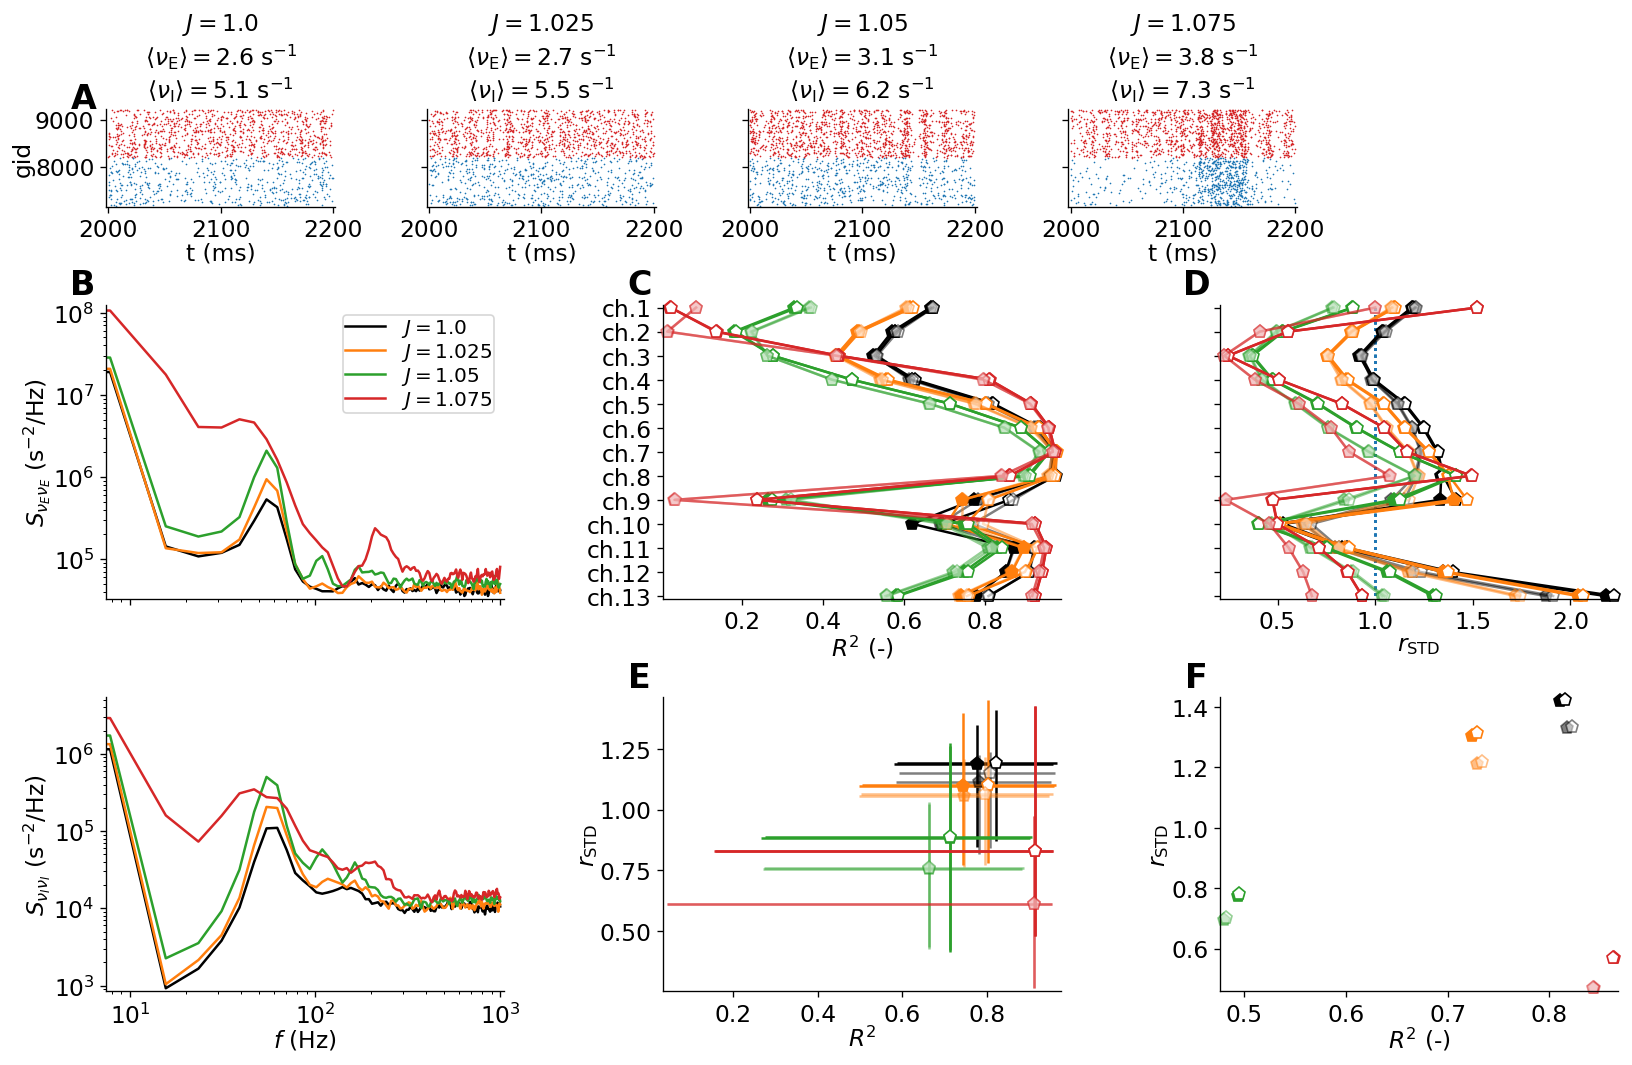

In [25]:
# outer iterator over the different ground truth datasets
T = [2000, 2200]
tstop = params.networkParameters['tstop']
dt = params.networkParameters['dt']
markersize = 8

fig = plt.figure(figsize=(figwidth, figwidth / golden_ratio))
gs = GridSpec(5, 5, left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.4, hspace=1)
gs2 = GridSpec(5, 3, left=0.05, right=0.95, bottom=0.1, top=0.95, wspace=0.4, hspace=1)
axes = [[], [], []]
for hh in range(PS_ref.num_conditions()):
    # rasters panels:
    if hh == 0:
        ax = fig.add_subplot(gs[0, hh])
    else:
        ax = fig.add_subplot(gs[0, hh], sharex=axes[0][0], sharey=axes[0][0])
    axes[0].append(ax)

for hh in range(3):
    axes[1].append(fig.add_subplot(gs2[1:3, hh]))
    axes[2].append(fig.add_subplot(gs2[3:, hh]))
    
for ax in flattenlist(axes):
    remove_axis_junk(ax)

annotate_subplot(axes[0][0], ncols=5, nrows=5, letter='A', linear_offset=0.02)
annotate_subplot(axes[1][0], ncols=3, nrows=5/1.5, letter='B', linear_offset=0.02)

for i, ax in enumerate(axes[1][1:]):
    annotate_subplot(ax, ncols=3, nrows=5/1.5, letter='CD'[i], linear_offset=0.02)
for i, ax in enumerate(axes[2][1:]):
    annotate_subplot(ax, ncols=3, nrows=5/1.5, letter='EF'[i], linear_offset=0.02)


# container
df = pd.DataFrame(columns=['R2', 'STD/STD', 'weight_scaling', 'probe', 'signal', 'channel'])
    
for hh, pset_ref in enumerate(PS_ref.iter_inner()):
    js_ref = json.dumps(pset_ref, sort_keys=True).encode()
    md5_ref = hashlib.md5(js_ref).hexdigest()
    OUTPUTPATH_REF = os.path.join('output', md5_ref)
    print(OUTPUTPATH_REF, os.path.isdir(OUTPUTPATH_REF))
    
    # plot spike raster
    ax = axes[0][hh]
    if hh >= 0:
        ax.set_ylabel('gid')  
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
    
    title = f"$J={pset_ref['weight_scaling']}$\n"
    with h5py.File(os.path.join(OUTPUTPATH_REF, 'spikes.h5'), 'r') as f:
        for i, y in enumerate(population_names):
            times = []
            gids = []

            for g, t in zip(f[y]['gids'], f[y]['times']):
                times = np.r_[times, t]
                gids = np.r_[gids, np.zeros(t.size) + g]

            gids = gids[times >= TRANSIENT]
            times = times[times >= TRANSIENT]

            ii = (times >= T[0]) & (times <= T[1]) & (gids >= -np.diff(population_sizes))
            ax.plot(times[ii], gids[ii], '.',
                    mfc=colors[i],
                    mec='none',
                    ms=2,
                    label=r'$\langle \nu_\mathrm{%s} \rangle =%.2f$ s$^{-1}$' % (
                        y, times.size / f[y]['gids'].size /
                        (tstop - TRANSIENT) * 1000))
            title = title + r'$\langle \nu_\mathrm{%s} \rangle =%.1f$ s$^{-1}$' % (
                        y, times.size / f[y]['gids'].size /
                        (tstop - TRANSIENT) * 1000)
            if i == 0:
                title = title + '\n'
    ax.set_title(title)
    # ax.legend(loc='upper right')
    ax.axis('tight')
    ax.invert_yaxis()
    ax.set_xlabel('t (ms)')
    if hh == 0:
        ax.set_ylabel('gid')  
    else:
        plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_ylabel('')
    
    
    # compute firing rate time series of "real" network
    tstop = networkParameters['tstop']
    nu_X, bins = methods.compute_nu_X(os.path.join(OUTPUTPATH_REF, 'spikes.h5'), population_names, 
                                           T=(0, tstop), Delta_t=dt)
            
    # plot rate spectra summing E and I spikes
    for i, X in enumerate(population_names):
        nu = nu_X[X] / (dt / 1000)

        nu = nu[int(TRANSIENT // dt):]
        w = pset_ref['weight_scaling']
        if w == 1.:
            color = 'k'
        else:
            color = f'C{hh}'    
        freqs, Pxx = ss.welch(nu, fs=Fs, nperseg=NFFT, noverlap=noverlap, detrend=detrend)
        ax = axes[i + 1][0]
        ax.loglog(freqs[freqs <= freqs_cutoff], Pxx[freqs <= freqs_cutoff],
                    color=color,
                    label=f'$J={w}$')
        ax.axis(ax.axis('tight'))
        if i==0:
            ax.legend(loc='upper right')
            plt.setp(ax.get_xticklabels(), visible=False)
        else:
            ax.set_xlabel('$f$ (Hz)')
        ax.set_ylabel(r'$S_{\nu_' + f'{X}' + r'\nu_' + f'{X}' + r'}$ (s$^{-2}$/Hz)')

    
    # compute and show R2 and STD ratio between ground truth and prediction
    for j, (fname, ylabel, probe, unit, vlimround) in enumerate(zip(
            ['RecExtElectrode.h5', 'CurrentDipoleMoment.h5'],
            [r'$V_\mathrm{e}$', r'$\mathbf{P}$'],
            ['GaussCylinderPotential', 'CurrentDipoleMoment'],
            ['mV', 'nAµm'],
            [2**-1, 2**18])):
        with h5py.File(os.path.join(OUTPUTPATH_REF, fname),
                       'r') as f:
            data_ref = f['data'][()]['E']
        
        # low pass filter, remove startup transient
        data_ref_lp = ss.sosfiltfilt(sos_ellip, data_ref)[:, int(TRANSIENT // dt):]
        data_ref = data_ref[:, int(TRANSIENT // dt):]

        # Compute reconstructed signals as the sum over convolutions
        # phi(r, t) = sum_X sum_Y (nu_X*H_YX)(r, t)
        for k, pset in enumerate(PS2.iter_inner()):
            pset['weight_scaling'] = pset_ref['weight_scaling']  # use reference value!
            
            # sorted json dictionary
            js = json.dumps(pset, sort_keys=True).encode()
            md5 = hashlib.md5(js).hexdigest()
            
            # signal container
            data = None

            for i, (X, N_X) in enumerate(zip(population_names,
                                             population_sizes)):
                for Y in ['E']: # population_names:
                    if data is None:
                        data = np.zeros((H_YX_pred_all[md5_ref][md5]['{}:{}'.format(Y, X)][probe].shape[0],
                                         nu_X[X].size))
                    for h, h_YX in enumerate(H_YX_pred_all[md5_ref][md5]['{}:{}'.format(Y, X)][probe]):
                        data[h, :] = data[h, :] + np.convolve(nu_X[X], h_YX,
                                                              'same')
            # low-pass filter, remove startup transient
            data_lp = ss.sosfiltfilt(sos_ellip, data)[:, int(TRANSIENT // dt):]
            data = data[:, int(TRANSIENT // dt):]
            
            # number of channels
            n_ch = data.shape[0]

            # Pearson correlation coefficients
            Pcc = np.corrcoef(data_ref, data)[n_ch:, :n_ch].diagonal()
            Pcc_lp = np.corrcoef(data_ref_lp, data_lp)[n_ch:, :n_ch].diagonal()

            # STD(y) / STD(x)
            scaling = data.std(axis=-1) / data_ref.std(axis=-1)
            scaling_lp = data_lp.std(axis=-1) / data_ref_lp.std(axis=-1)

            for ch in range(n_ch):
                df = df.append([
                        pd.DataFrame(
                            data={'R2': Pcc[ch]**2, 'STD/STD': scaling[ch], 
                                  'weight_scaling': pset_ref['weight_scaling'],
                                  'perseg_Vrest': pset['perseg_Vrest'],
                                  'probe': probe,
                                  'signal': 'raw', 'channel': (ch + 1)}, 
                            index=[0]
                        ),
                        pd.DataFrame(
                            data={'R2': Pcc_lp[ch]**2, 'STD/STD': scaling_lp[ch], 
                                  'weight_scaling': pset_ref['weight_scaling'], 
                                  'perseg_Vrest': pset['perseg_Vrest'],
                                  'probe': probe,
                                  'signal': 'LP', 'channel': (ch + 1)}, 
                            index=[0]
                        ),
                        ],
                    ignore_index=True)
            
            # plot
            w = pset_ref['weight_scaling']
            if w == 1.:
                color = 'k'
            else:
                color = f'C{hh}'
            alpha = 0.5 if pset['perseg_Vrest'] else 1
            if probe == 'CurrentDipoleMoment':
                ax = axes[2][2]
                
                ax.plot(Pcc[2]**2, scaling[2], 'p', mec=color, mfc=color, alpha=alpha, ms=markersize, 
                        label=f'$J={w}$; raw', clip_on=False)
                ax.plot(Pcc_lp[2]**2, scaling_lp[2], 'p', mec=color, alpha=alpha, mfc='w', ms=markersize, 
                        label=f'$J={w}$; LP', clip_on=False)
                ax.set_ylabel(r'$r_\mathrm{STD}$')
                ax.set_xlabel(r'$R^2$ (-)')
            else:
                ax = axes[1][1]

                ax.plot(Pcc**2, np.arange(n_ch) + 1, '-p', color=color, alpha=alpha, ms=markersize, 
                        label=f'$J={w}$; raw', clip_on=False)
                ax.plot(Pcc_lp**2, np.arange(n_ch) + 1, '-p', color=color, alpha=alpha, mfc='w', ms=markersize, 
                        label=f'$J={w}$; LP', clip_on=False)
                ax.set_xlabel(r'$R^2$ (-)')
                # ax.set_xlim(xmax=1)

                ax = axes[1][2]
                ax.plot(scaling, np.arange(n_ch) + 1, '-p', color=color, alpha=alpha, ms=markersize, clip_on=False)
                ax.plot(scaling_lp, np.arange(n_ch) + 1, '-p', color=color, alpha=alpha, mfc='w', ms=markersize, clip_on=False)
                ax.set_xlabel(r'$r_\mathrm{STD}$')

                for ax in axes[1][1:]:
                    ax.set_yticks(np.arange(n_ch) + 1)
                    ax.set_yticklabels(['ch.{}'.format(i + 1) for i in np.arange(n_ch)])
                plt.setp(axes[1][2].get_yticklabels(), visible=False)

                axes[1][2].vlines(1, 1, n_ch, ls=':')
                
df_agg = df.groupby(['signal', 'weight_scaling', 'probe', 'perseg_Vrest'], as_index=False
                    ).agg({'R2': ['mean', 'median', methods.quant10, methods.quant90], 
                           'STD/STD': ['mean', 'median', methods.quant10, methods.quant90]})

ax = axes[2][1]
markers = 'p'
weight_scaling = list(PS0['weight_scaling'])
probe = 'GaussCylinderPotential'
for i, weight in enumerate(weight_scaling):
    for j, signal in enumerate(['raw', 'LP']):
        for h, perseg_Vrest in enumerate([False, True]):
            d = df_agg[(df_agg['weight_scaling'] == weight) & 
                       (df_agg['signal'] == signal) & 
                       (df_agg['probe'] == probe) & 
                       (df_agg['perseg_Vrest'] == perseg_Vrest)]
            color = f'C{i}' if weight != 1. else 'k'
            alpha = 0.5 if perseg_Vrest else 1


            ax.errorbar(x=d['R2']['median'], 
                        y=d['STD/STD']['median'],
                        xerr=np.c_[d['R2']['median'] - d['R2']['quant10'], 
                                   d['R2']['quant90'] - d['R2']['median']].T,
                        yerr=np.c_[d['STD/STD']['median'] - d['STD/STD']['quant10'], 
                                   d['STD/STD']['quant90'] - d['STD/STD']['median']].T,
                        fmt=markers, 
                        ms=markersize,
                        ecolor=color,
                        mec=color,
                        mfc='w' if signal == 'LP' else color,
                        alpha=alpha,
                        label=weight_scaling if j == 0 else '_nolegend_')
ax.set_ylabel(r'$r_\mathrm{STD}$')
ax.set_xlabel('$R^2$')


for ax in axes[1][1:]:
    ax.invert_yaxis()
#for ax in [axes[1][1], axes[2][2]]:
    # ax.legend(loc='best')
    # ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# fig.savefig('figures/figure11_Hay.pdf', bbox_inches='tight')

In [21]:
df

,R2,STD/STD,weight_scaling,probe,signal,channel,perseg_Vrest
0,0.665987,1.187606,1.000,GaussCylinderPotential,raw,1,False
1,0.672322,1.192841,1.000,GaussCylinderPotential,LP,1,False
2,0.570682,1.033131,1.000,GaussCylinderPotential,raw,2,False
3,0.577853,1.038988,1.000,GaussCylinderPotential,LP,2,False
4,0.523938,0.918853,1.000,GaussCylinderPotential,raw,3,False
...,...,...,...,...,...,...,...
251,0.059114,9.680813,1.075,CurrentDipoleMoment,LP,1,True
252,0.052503,19.720401,1.075,CurrentDipoleMoment,raw,2,True
253,0.066288,22.180737,1.075,CurrentDipoleMoment,LP,2,True
254,0.843536,0.468736,1.075,CurrentDipoleMoment,raw,3,True


In [22]:
# aggregated mean and standard deviations etc. of R2 and STD ratio
df_agg

signal weight_scaling                   probe perseg_Vrest        R2  \
                                                                   mean   
0      LP          1.000     CurrentDipoleMoment        False  0.272050   
1      LP          1.000     CurrentDipoleMoment         True  0.274253   
2      LP          1.000  GaussCylinderPotential        False  0.793339   
3      LP          1.000  GaussCylinderPotential         True  0.797960   
4      LP          1.025     CurrentDipoleMoment        False  0.243169   
5      LP          1.025     CurrentDipoleMoment         True  0.244855   
6      LP          1.025  GaussCylinderPotential        False  0.766112   
7      LP          1.025  GaussCylinderPotential         True  0.761800   
8      LP          1.050     CurrentDipoleMoment        False  0.166136   
9      LP          1.050     CurrentDipoleMoment         True  0.161688   
10     LP          1.050  GaussCylinderPotential        False  0.612416   
11     LP          1.050  GaussCylinderPotential         True  0.597150   
12     LP          1.075     CurrentDipoleMoment        False  0.328815   
13     LP          1.075     CurrentDipoleMoment         True  0.322682   
14     LP          1.075  GaussCylinderPotential        False  0.699642   
15     LP          1.075  GaussCylinderPotential         True  0.673491   
16    raw          1.000     CurrentDipoleMoment        False  0.270359   
17    raw          1.000     CurrentDipoleMoment         True  0.272580   
18    raw          1.000  GaussCylinderPotential        False  0.766054   
19    raw          1.000  GaussCylinderPotential         True  0.770089   
20    raw          1.025     CurrentDipoleMoment        False  0.241365   
21    raw          1.025     CurrentDipoleMoment         True  0.243043   
22    raw          1.025  GaussCylinderPotential        False  0.747260   
23    raw          1.025  GaussCylinderPotential         True  0.742906   
24    raw          1.050     CurrentDipoleMoment        False  0.165399   
25    raw          1.050     CurrentDipoleMoment         True  0.160894   
26    raw          1.050  GaussCylinderPotential        False  0.607231   
27    raw          1.050  GaussCylinderPotential         True  0.592172   
28    raw          1.075     CurrentDipoleMoment        False  0.320415   
29    raw          1.075     CurrentDipoleMoment         True  0.314089   
30    raw          1.075  GaussCylinderPotential        False  0.700121   
31    raw          1.075  GaussCylinderPotential         True  0.673688   

                                    STD/STD                                 
      median   quant10   quant90       mean    median   quant10    quant90  
0   0.000471  0.000144  0.652587   2.747666  1.950340  1.529346   4.284918  
1   0.000473  0.000151  0.657867   2.659448  1.833120  1.434905   4.214522  
2   0.821254  0.587609  0.967257   1.203586  1.192841  0.869939   1.410744  
3   0.808974  0.592174  0.962179   1.132724  1.149219  0.840411   1.236069  
4   0.000537  0.000109  0.583283   2.974015  2.233697  1.497238   4.746920  
5   0.000560  0.000112  0.587316   2.846174  1.983159  1.371198   4.666355  
6   0.803699  0.504375  0.965347   1.134722  1.101226  0.780360   1.452479  
7   0.795702  0.503717  0.956584   1.043816  1.062311  0.771549   1.217337  
8   0.002420  0.001262  0.396497   3.817899  4.243316  1.474298   5.991333  
9   0.002096  0.001188  0.386023   3.412912  3.054410  1.171977   5.797248  
10  0.714345  0.275138  0.907134   0.853498  0.888646  0.419532   1.273335  
11  0.663601  0.273991  0.889097   0.734236  0.760830  0.431867   1.031889  
12  0.071995  0.055709  0.704649  13.883178  8.520727  2.158597  27.752740  
13  0.066288  0.060549  0.687373  10.776933  9.680813  2.311562  19.680752  
14  0.914590  0.154864  0.957806   0.834230  0.828407  0.480370   1.427343  
15  0.911557  0.044080  0.954853   0.608163  0.609390  0.264716   0.974331  
16  0.000315  0.000097  0.648640   2.376705  1.650709  1.465098   